In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import EfficientNetB4
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.utils import class_weight
import numpy as np
import os

# Check for GPU
num_gpus = len(tf.config.list_physical_devices('GPU'))
print(f"Num GPUs Available: {num_gpus}")

# --- NEW: Distribution Strategy ---
if num_gpus > 1:
    strategy = tf.distribute.MirroredStrategy()
    print('Distribution strategy: MirroredStrategy (using multiple GPUs)')
else:
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0") # Or "/cpu:0" if no GPU
    print('Distribution strategy: OneDeviceStrategy (using a single GPU or CPU)')
# ---------------------------------

2025-12-03 16:32:16.538023: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764779536.768985      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764779536.837950      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Num GPUs Available: 2
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Distribution strategy: MirroredStrategy (using multiple GPUs)


I0000 00:00:1764779554.835206      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764779554.835770      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [2]:
# Define parameters
IMG_SIZE = (380, 380)

# Since we have 2 GPUs, we can double the batch size for better efficiency.
BATCH_SIZE_PER_REPLICA = 32
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * num_gpus
LR = 0.001
EPOCHS = 50 # MAX

print(f"Using a global batch size of: {BATCH_SIZE}")

# Kaggle dataset paths
train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'
val_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'

# 1. Define Generators (No change here)
train_datagen = ImageDataGenerator(
    # rescale=1./255,
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# 2. Create Directory Iterators
train_gen = train_datagen.flow_from_directory(
    '/kaggle/input/chest-xray-pneumonia/chest_xray/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    '/kaggle/input/chest-xray-pneumonia/chest_xray/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# 2.5. Create the Test Directory Iterator (The Missing Piece)
# Note: Use shuffle=False for reproducible evaluation
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# 3. CONVERT TO tf.data.Dataset (The Fix!)
# This wrapper handles the multi-GPU splitting logic safely

def tf_data_generator(generator, input_shape):
    num_classes = generator.num_classes
    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None, *input_shape], [None, num_classes])
    )
    return dataset

# Wrap Train Set
train_dataset = tf_data_generator(train_gen, (IMG_SIZE[0], IMG_SIZE[1], 3))
train_dataset = train_dataset.unbatch().batch(BATCH_SIZE, drop_remainder=True)
train_dataset = train_dataset.repeat() # Loops indefinitely
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

# Wrap Validation Set
val_dataset = tf_data_generator(val_gen, (IMG_SIZE[0], IMG_SIZE[1], 3))
val_dataset = val_dataset.unbatch().batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.repeat()
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

# Calculate Steps per Epoch (Since we use .repeat(), we must specify steps manually)
steps_per_epoch = train_gen.samples // BATCH_SIZE
validation_steps = val_gen.samples // BATCH_SIZE
# Calculate steps to cover the whole test set
test_steps = int(np.ceil(test_gen.samples / BATCH_SIZE))

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")
print(f"Test steps: {test_steps}")

# 4. Class Weights (Recalculate)
train_classes = train_gen.classes
class_weights_vals = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_classes),
    y=train_classes
)
class_weights_dict = dict(enumerate(class_weights_vals))

Using a global batch size of: 64
Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Steps per epoch: 65
Validation steps: 16
Test steps: 10


In [3]:
# Wrap Model Definition and Compilation in the strategy scope
with strategy.scope():
    # 1. Load EfficientNetB4 with ImageNet weights, excluding the top layers
    base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

    # 2. Freeze the convolutional layers
    for layer in base_model.layers:
        layer.trainable = False

    # 3. Add the new classification layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x) # "Bottleneck" features
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)  # Drops 50% of connections to prevent overfitting
    
    # --- L2 REGULARIZATION ADDED HERE ---
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x) 
    x = Dropout(0.5)(x)         
    
    # --- L2 REGULARIZATION ADDED HERE ---
    predictions = Dense(train_gen.num_classes, activation='softmax', kernel_regularizer=l2(0.01))(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    # The optimizer is now initialized within the strategy scope
    model.compile(optimizer=Adam(learning_rate=LR),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# --- Callbacks ---
# 1. Save the best model (Persist progress)
checkpoint_callback = ModelCheckpoint(
    filepath='/kaggle/working/InceptionV3_pneumonia_best.weights.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# 2. Stop early if no improvement (Replicates paper's behavior [cite: 332])
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',   # Watch validation accuracy
    patience=10,              # Stop if it doesn't improve for 10 epochs
    restore_best_weights=True # Go back to the best version automatically
)

# Put all callbacks into a list
callbacks_list = [checkpoint_callback, early_stopping_callback]

In [5]:
# Train the model
print("Starting training on multiple GPUs...")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    class_weight=class_weights_dict,
    callbacks=callbacks_list
)

Starting training on multiple GPUs...
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Epoch 1/50
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 6 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 al

E0000 00:00:1764779586.903868      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1764779592.690104      59 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1764779592.690119      60 cuda_dnn.cc:529] Loaded cuDNN version 90300


65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5132 - loss: 3.5807INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1

Epoch 1:

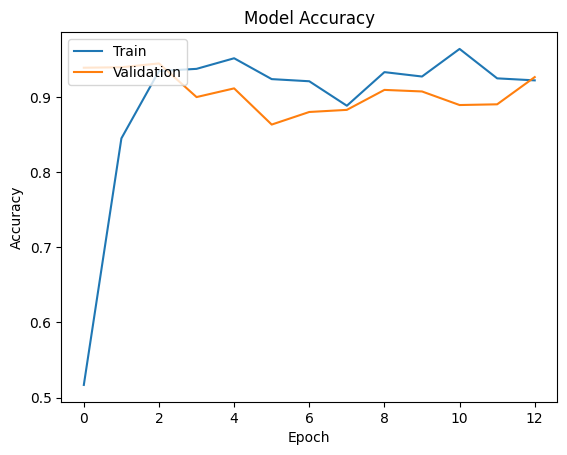

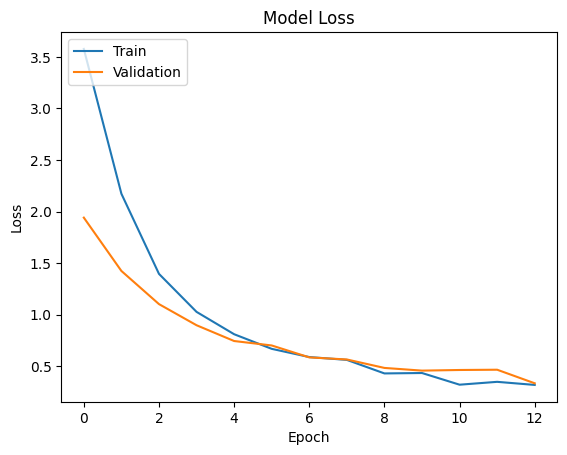

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 978ms/step - accuracy: 0.8526 - loss: 1.2881
Test Loss: 1.2863
Test Accuracy: 84.96%


In [6]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Final Evaluation on Test Set
test_loss, test_acc = model.evaluate(test_gen, steps=test_steps)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc*100:.2f}%")